# Import Packages


In [ ]:
# Importing requried packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.optimizers as O
import tensorflow.keras.losses as Lo
!pip install tensorflow_text
import tensorflow_text as text

from tqdm.notebook import tqdm

import os
import random
import re

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import defaultdict

from joblib import Parallel, delayed

In [ ]:
# Importing NLP libraries for data preprocesing - text tokenization

nltk.download('all')
stop_words = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())
words = [w.lower() for w in words]
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [ ]:
# Defining the Constants in the code

BATCH_SIZE=8
EPOCHS=80

In [3]:
# Setting up the file path and loading data

file_path = '/content/drive/MyDrive/Zycus/train'
train_data = pd.read_csv(os.path.join(file_path,'train.csv'))
test_data = pd.read_csv(os.path.join(file_path,'prediction.csv'))
files = os.listdir(os.path.join(file_path,'full_contract_txt/'))

In [504]:
train_data.head()

,file,Start Date,Start Date-Answer
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,['This agreement shall begin upon the date of ...,[]/[]/[]
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,"['July 11 , 2006']",7/11/2006
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,"['November 15, 2012']",11/15/2012
3,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,"['Feb 10, 2014']",2/10/2014
4,IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...,"['December 21, 2015']",12/21/2015


#Data Cleaning

In [ ]:
# Identifying different filetypes in the given csv file to be changed to .txt file as per the given text files.

val = set()
for i in range(len(train_data)):
    val.add(train_data.file.values[i][-4:])

print(val)

In [506]:
# Clearing the exeption cases individually

for i in range(len(train_data)):
    if train_data.file.values[i][-4:] == "PDF'":
        print(train_data.file[i])

train_data['file'].replace("KALLOINC_11_03_2011-EX-10.1-STRATEGIC ALLIANCE AGREEMENT.PDF'",
                           "KALLOINC_11_03_2011-EX-10.1-STRATEGIC ALLIANCE AGREEMENT.PDF",
                           inplace=True)

In [8]:
def change_ext(data):
    """ 
    
    Function to change extension text in the csv files 
    
    """

    return data[:-4] + '.txt'

In [ ]:
# Identifying the exception cases whose extension was not changed

counter = 0
missing = []
files = os.listdir(os.path.join(file_path,'full_contract_txt/'))
train_data.file = train_data.file.apply(change_ext)
for i in range(len(train_data)):
    if train_data.file.values[i] not in files:
        print(train_data.iloc[i])
        missing.append(train_data.file.values[i])
        counter+=1
print(len(files),counter)  

In [11]:
# Replacing the exception cases with the correct values in the csv file

new_vals = ["PLAYAHOTELS_RESORTSNV_03_14_2017-EX-10.22-STRATEGIC ALLIANCE AGREEMENT (Hyatt Ziva Cancun).txt",
            "MACY_S,INC_05_11_2020-EX-99.4-JOINT FILING AGREEMENT.txt",
            "MOELIS_CO_03_24_2014-EX-10.19-STRATEGIC ALLIANCE AGREEMENT.txt"]
train_data.file.replace(missing,new_vals,inplace=True)

In [507]:
# Filling the Nan values in the csv file with []/[]/[] value

train_data['Start Date-Answer'].fillna('[]/[]/[]',inplace=True)

# Data Preprocessing

In [15]:
# Fetching and storing the data in the text files

data = []
for i in range(len(train_files)):
    with open(os.path.join(file_path,'full_contract_txt/'+train_files[i]),'r') as f:
        data.append(f.read())

In [496]:
def preprocess_text(text_array):
    """ 
    
    Function to preprocess the texts by tokenizing, lemmatizing, removing stopwords and punctuations,etc 
        
        Inputs: Text string 
        Return: list of tokenized text values
    
    """

    processed_text = []
    for i in tqdm(range(len(text_array))):
        text = text_array[i]
        text = word_tokenize(text)
        text = [w for w in text[:500] if not w.lower() in stop_words]
        for i in range(len(text)):
            if text[i].isdigit() == False and text[i].isalpha() == False:
                temp = text[i]
                text[i] = ''
                for k in temp:
                    if k.isdigit() == True:
                        text[i] += k 
        
        text = ''.join([w.lower() for w in ' '.join(text) if w not in string.punctuation])
        text = word_tokenize(text)
        text = [wordnet_lemmatizer.lemmatize(w,pos='v') for w in text]
        text = [w for w in text if w.lower() in words or w.isdigit() == True]
        processed_text.append(text)
    return processed_text

class vectorizer():
    def __init__(self,):
        self.word2vec = defaultdict(lambda:0)
        self.day2vec = defaultdict(lambda:0)
        self.month2vec = defaultdict(lambda:0)
        self.year2vec = defaultdict(lambda:0)
    
    def fit(self,text_array):
        """ 
    
        Function to prepare a word to vector dictionary from the input data 
        
          Inputs: list of text values 
    
        """
        counter = 1
        for i in range(len(text_array)):
            for j in range(len(text_array[i])):
                if text_array[i][j] not in self.word2vec.keys():
                    counter+=1
                    self.word2vec[text_array[i][j]] = counter

    def vectorize(self,text_array,max_len=None):        
        """ 
    
        Function to vecotrize the texts data in integers values for the computer to understand 
        
            Inputs: Array of list of text values, maximum length of tokenization 
            Return: Array of list of integers values
    
        """

        if max_len == None:
            max_len = max([len(x) for x in text_array])        
        
        vectorized_array = np.zeros((len(text_array), max_len),dtype='int32')
        for i in range(len(text_array)):
            for j in range(len(text_array[i])):
                if j== max_len:
                    break
                vectorized_array[i][j] = self.word2vec[text_array[i][j]]

        return vectorized_array

    def inverse_vectorize(self,array):
        """ 
    
        Function to inverse vecotrize the integer data to text values for humans to understand 
        
            Inputs: Array of list of integers 
            Return: Array of text values
    
        """
        
        max_len = len(array[0])
        vec2word = {v:k for k,v in self.word2vec.items()}
        inverse_vector = []
        for i in range(len(array)):
            temp_vec = []
            for j in range(len(array[i])):
                if array[i][j] == 0:
                    break
                temp_vec.append(vec2word[array[i][j]])
            inverse_vector.append(' '.join(temp_vec))
        return inverse_vector
    
    def vectorize_pred(self,text_array,max_len=3):
        """ 
    
        Function to specifically vecotrize the texts data in lables to integers values for the computer to understand 
        
            Inputs: Array of list of text values, maximum length of tokenization 
            Return: Lists of vectorized days, months and years
    
        """

        for i in range(1,32):
            self.day2vec[str(i)] = i
        for i in range(1,13):
            self.month2vec[str(i)] = i
        for i in range(1,51):
            self.year2vec[str(i+1980)] = i
        day = []
        month = []
        year = []
        for i in range(len(text_array)):
            if text_array[i][1][0] == '0':
                temp_vec = self.day2vec[text_array[i][1][1]]    
            else:
                temp_vec = self.day2vec[text_array[i][1]]
            day.append(temp_vec)
            if text_array[i][0][0] == '0':
                temp_vec = self.month2vec[text_array[i][0][1]]    
            else:
                temp_vec = self.month2vec[text_array[i][0]]
            month.append(temp_vec)
            temp_vec = self.year2vec[text_array[i][2]]
            year.append(temp_vec)
        
        return month, day, year

In [319]:
data_vectorizer = vectorizer()
d = preprocess_text(data)
data_vectorizer.fit(d)
x_train = data_vectorizer.vectorize(d)

In [322]:
# Preprocessing of cav file

def remove_slash(data):
    """ 
    
    Function to replace slash with whitespace in the csv file (pandas DataFrame) 
    
    """
    return data.replace('/',' ')


y_train = train_data['Start Date-Answer'].apply(remove_slash).values

# tokenization and vecotrization of label data

for i in range(len(y_train)):
    y_train[i] = tokenizer.tokenize(y_train[i])

y_month,y_day,y_year = data_vectorizer.vectorize_pred(y_train)

In [324]:
# Onehot encoding the label data for loss calculation and training

y_month = tf.one_hot(y_month,depth=13)
y_day = tf.one_hot(y_day,depth=32)
y_year = tf.one_hot(y_year,depth=50)

## Data Split

In [325]:
# Splitting data in Valdiation and training sets

x_val = x_train[400:]
x_train = x_train[:400]
y_val_day = y_day[400:]
y_val_month = y_month[400:]
y_val_year = y_year[400:]
y_day = y_day[:400]
y_month = y_month[:400]
y_year = y_year[:400]

In [508]:
# Preperation of tensorflow tf.data pipeline ro input in the model

dataset = tf.data.Dataset.from_tensor_slices((x_train,(y_month,y_day,y_year))).shuffle(16).batch(BATCH_SIZE).cache().repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,(y_val_month,y_val_day,y_val_year))).batch(1).cache().prefetch(tf.data.AUTOTUNE)

# Build Model

In [436]:
# Defining the function to build a Recurrent Nerual network (RNN) model

def build_model():
    """ 
    
    This function builds a model to be trained 

    Returns: Tensorflow/keras model 
    
    """
    
    decay_lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001,decay_steps=10000,decay_rate=0.96,staircase=True)
    adam = O.Adam(learning_rate=decay_lr)
    loss_object = Lo.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

    text_input = tf.keras.layers.Input(shape=(x_train.shape[1],))
    x = L.Embedding(len(data_vectorizer.word2vec),1000,name='Input1')(text_input)
    x = L.Bidirectional(L.LSTM(32))(x)
    # x2 = L.Embedding(len(data_vectorizer.word2vec),100,name='Input2')(text_input)
    # x2 = L.Bidirectional(L.LSTM(32))(x2)
    # x3 = L.Embedding(len(data_vectorizer.word2vec),100,name='Input3')(text_input)
    # x3 = L.Bidirectional(L.LSTM(32))(x3)
    # x = tf.expand_dims(x,axis=1)
    x1 = L.Dense(512,activation='relu')(x)
    x1 = L.Dense(256,activation='relu')(x1)
    x1 = L.Dropout(0.5)(x1)
    x1 = L.Dense(128,activation='relu')(x1)
    x1 = L.Dense(13,kernel_initializer='glorot_uniform',activation='softmax',name='out1')(x1)
    x2 = L.Dense(512,activation='relu')(x)
    x2 = L.Dense(256,activation='relu')(x2)
    x2 = L.Dropout(0.5)(x2)
    x2 = L.Dense(128,activation='relu')(x2)
    x2 = L.Dense(32,kernel_initializer='glorot_uniform',activation='softmax',name='out2')(x2)
    x3 = L.Dense(512,activation='relu')(x)
    x3 = L.Dense(256,activation='relu')(x3)
    x3 = L.Dropout(0.5)(x3)
    x3 = L.Dense(128,activation='relu')(x3)
    x3 = L.Dense(50,kernel_initializer='glorot_uniform',activation='softmax',name='out3')(x3)
    
    model = M.Model(inputs=text_input,outputs=[x1,x2,x3])
    
    model.compile(optimizer=adam,loss={'out1':'categorical_crossentropy','out2':'categorical_crossentropy','out3':'categorical_crossentropy'},metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

model = build_model()
model.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 375)]        0           []                               
                                                                                                  
 Input1 (Embedding)             (None, 375, 1000)    5655000     ['input_45[0][0]']               
                                                                                                  
 bidirectional_60 (Bidirectiona  (None, 64)          264448      ['Input1[0][0]']                 
 l)                                                                                               
                                                                                                  
 dense_390 (Dense)              (None, 512)          33280       ['bidirectional_60[0][0]']

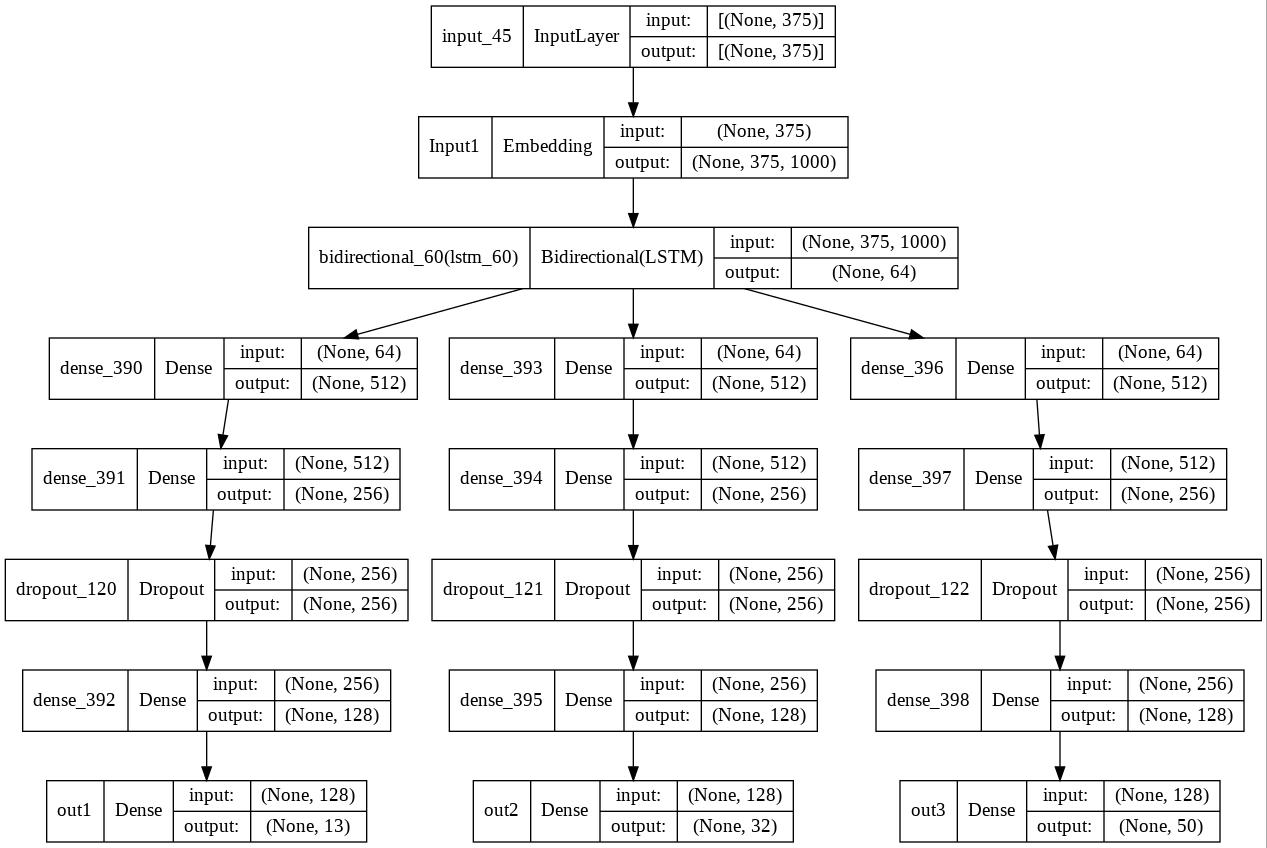

In [437]:
# Saving and printing the model Architecture

tf.keras.utils.plot_model(model, to_file='abc.jpeg', show_shapes=True)

#Training

In [ ]:
# Model training

history = model.fit(dataset,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    validation_data=val_dataset,
                    validation_batch_size=1)

In [410]:
# Saving the Model

model.save('/content/drive/MyDrive/Zycus/model_file.h5')

In [509]:
# Loading the model 

model = M.load_model('/content/drive/MyDrive/Zycus/model_file.h5')

# Inference

## Test Data Cleaning

In [518]:
test_data.head()

,file,value
0,BNCMORTGAGEINC_05_17_1999-EX-10.4-LICENSING AN...,NaN
1,CORIOINC_07_20_2000-EX-10.5-LICENSE AND HOSTIN...,NaN
2,CHANGEPOINTCORP_03_08_2000-EX-10.6-LICENSE AND...,NaN
3,INKTOMICORP_06_08_1998-EX-10.14-SOFTWARE HOSTI...,NaN
4,"ADMA BioManufacturing, LLC - Amendment #3 to ...",NaN


In [519]:
# Identifying different filetypes in the given csv file to be changed to .txt file as per the given text files.

val = set()
for i in range(len(test_data)):
    val.add(test_data.file.values[i][-4:])

print(val)

{'.pdf', '.PDF'}


In [520]:
# Updating the extention of the file values in the test data csv file and Identifying the exception cases

counter = 0
missing = []
files = os.listdir(os.path.join(file_path,'full_contract_txt/'))
test_data.file = test_data.file.apply(change_ext)
for i in range(len(test_data)):
    if test_data.file.values[i] not in files:
        print(test_data.iloc[i][0])
        missing.append(test_data.file.values[i])
        counter+=1
print(len(files),counter)  

Monsanto Company - SECOND A&R EXCLUSIVE AGENCY AND MARKETING AGREEMENT .txt
PACIRA PHARMACEUTICALS, INC. - A&R STRATEGIC LICENSING, DISTRIBUTION AND MARKETING AGREEMENT .txt
SightLife Surgical, Inc. - STRATEGIC SALES & MARKETING AGREEMENT.txt
NETGEAR,INC_04_21_2003-EX-10.16-AMENDMENT TO THE DISTRIBUTOR AGREEMENT BETWEEN INGRAM MICRO AND NETGEAR-.txt
511 4


In [521]:
# Replacing the exception cases with the correct values

new_vals = ["Monsanto Company - SECOND A_R EXCLUSIVE AGENCY AND MARKETING AGREEMENT .txt",
            "PACIRA PHARMACEUTICALS, INC. - A_R STRATEGIC LICENSING, DISTRIBUTION AND MARKETING AGREEMENT .txt",
            "SightLife Surgical, Inc. - STRATEGIC SALES _ MARKETING AGREEMENT.txt",
            "NETGEAR,INC_04_21_2003-EX-10.16-AMENDMENT TO THE DISTRIBUTOR AGREEMENT BETWEEN INGRAM MICRO AND NETGEAR.txt"]

test_data.file.replace(missing,new_vals,inplace=True)

## Test Data Preprocessing

In [446]:
# Fetching and storing the test data from the txt files in variables

test_files = test_data.file.values

t_data = []
for i in range(len(test_files)):
    with open(os.path.join(file_path,'full_contract_txt/'+test_files[i]),'r') as f:
        t_data.append(f.read())

In [447]:
# Preprocessing and preperatopm of test data to be provided as input to the model for prediction

x_test = preprocess_text(t_data)
x_test = data_vectorizer.vectorize(x_test,max_len=x_train.shape[1])

test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(1).prefetch(tf.data.AUTOTUNE)

  0%|          | 0/48 [00:00<?, ?it/s]

['exhibit', '1010', 'confidential', 'treatment', 'request', 'information', 'confidential', 'treatment', 'request', 'omit', 'mark', 'unredacted', 'version', 'document', 'also', 'furnish', 'separately', 'exchange', 'commission', 'require', 'rule', '406', 'act', '1933', 'amend', 'master', 'development', 'manufacture', 'agreement', 'master', 'development', 'manufacture', 'agreement', 'include', 'appendices', 'hereto', 'agreement', 'enter', 'february', '13', '2018', 'effective', 'date', 'magenta', 'therapeutics', 'delaware', 'corporation', '50', 'hampshire', 'street', '8', 'h', 'floor', '02139', 'magenta', 'california', 'corporation', '3132', 'street', 'ca', '90505', 'magenta', 'may', 'refer', 'individually', 'party', 'collectively', 'party', 'whereas', 'magenta', 'engage', 'development', 'research', 'certain', 'pharmaceutical', 'require', 'assistance', 'development', 'manufacture', 'active', 'pharmaceutical', 'clinical', 'whereas', 'contract', 'manufacturer', 'possess', 'necessary', 'techn

## Prediction

In [490]:
# Predicting the month, day and year from the given text data

pred_month,pred_day,pred_year = model.predict(test_dataset)

In [492]:
# Post processing the data to be understood by humans

pred = np.empty((len(pred_month),3),dtype='int32')

pred_month = np.argmax(pred_month,axis=-1)
pred_day = np.argmax(pred_day,axis=-1)
pred_year = np.argmax(pred_year,axis=-1)

for i in range(len(pred_month)):
    pred[i][0] = pred_month[i]
    pred[i][1] = pred_day[i]
    pred[i][2] = pred_year[i]+1980

result = [str(pred[i][0])+'/'+str(pred[i][1])+'/'+str(pred[i][2]) for i in range(len(pred))]

In [524]:
# Stroing the data in the prediction.csv file

test_data['value'] = result
test_data['value'] = test_data['value'].apply(lambda x: x.replace('0/','[]/'))
test_data.to_csv('Prediction.csv',index=False)

In [525]:
test_data.head()

,file,value
0,BNCMORTGAGEINC_05_17_1999-EX-10.4-LICENSING AN...,3/29/1995
1,CORIOINC_07_20_2000-EX-10.5-LICENSE AND HOSTIN...,11/23/1997
2,CHANGEPOINTCORP_03_08_2000-EX-10.6-LICENSE AND...,11/3/2012
3,INKTOMICORP_06_08_1998-EX-10.14-SOFTWARE HOSTI...,12/21/1999
4,"ADMA BioManufacturing, LLC - Amendment #3 to ...",2/3/2004
